In [1]:
import SimpleITK as sitk
import numpy as np
import csv
import scipy
from glob import glob
import pandas as pd
from scipy import ndimage
from tqdm import tqdm 
import pandas as pd
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import dicom
import scipy.misc

from skimage import measure, morphology, segmentation
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from numba import autojit
from PIL import Image
import cv2
import random


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
from keras import backend as K
K.set_image_dim_ordering('th') 

from keras.models import Sequential,load_model,Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Input, merge, UpSampling2D
from keras.optimizers import Adam, SGD, RMSprop, Nadam
from keras.preprocessing.image import ImageDataGenerator

from keras.layers.convolutional import Convolution3D, MaxPooling3D, UpSampling3D
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.core import SpatialDropout3D
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

from utils_3d import *
from paths import *

%matplotlib inline

Using TensorFlow backend.


In [2]:
def unet_model():
    
    inputs = Input(shape=(1, max_slices, img_size, img_size))
    conv1 = Convolution3D(width, 3, 3, 3, activation = 'relu', border_mode='same')(inputs)
    conv1 = BatchNormalization(axis = 1)(conv1)
    conv1 = Convolution3D(width*2, 3, 3, 3, activation = 'relu', border_mode='same')(conv1)
    conv1 = BatchNormalization(axis = 1)(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2), border_mode='same')(conv1)
    
    conv2 = Convolution3D(width*2, 3, 3, 3, activation = 'relu', border_mode='same')(pool1)
    conv2 = BatchNormalization(axis = 1)(conv2)
    conv2 = Convolution3D(width*4, 3, 3, 3, activation = 'relu', border_mode='same')(conv2)
    conv2 = BatchNormalization(axis = 1)(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2), border_mode='same')(conv2)

    conv3 = Convolution3D(width*4, 3, 3, 3, activation = 'relu', border_mode='same')(pool2)
    conv3 = BatchNormalization(axis = 1)(conv3)
    conv3 = Convolution3D(width*8, 3, 3, 3, activation = 'relu', border_mode='same')(conv3)
    conv3 = BatchNormalization(axis = 1)(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2), border_mode='same')(conv3)
    
    conv4 = Convolution3D(width*8, 3, 3, 3, activation = 'relu', border_mode='same')(pool3)
    conv4 = BatchNormalization(axis = 1)(conv4)
    conv4 = Convolution3D(width*8, 3, 3, 3, activation = 'relu', border_mode='same')(conv4)
    conv4 = BatchNormalization(axis = 1)(conv4)
    conv4 = Convolution3D(width*16, 3, 3, 3, activation = 'relu', border_mode='same')(conv4)
    conv4 = BatchNormalization(axis = 1)(conv4)

    up5 = merge([UpSampling3D(size=(2, 2, 2))(conv4), conv3], mode='concat', concat_axis=1)
    conv5 = SpatialDropout3D(dropout_rate)(up5)
    conv5 = Convolution3D(width*8, 3, 3, 3, activation = 'relu', border_mode='same')(conv5)
    conv5 = Convolution3D(width*8, 3, 3, 3, activation = 'relu', border_mode='same')(conv5)
    
    up6 = merge([UpSampling3D(size=(2, 2, 2))(conv5), conv2], mode='concat', concat_axis=1)
    conv6 = SpatialDropout3D(dropout_rate)(up6)
    conv6 = Convolution3D(width*4, 3, 3, 3, activation = 'relu', border_mode='same')(conv6)
    conv6 = Convolution3D(width*4, 3, 3, 3, activation = 'relu', border_mode='same')(conv6)

    up7 = merge([UpSampling3D(size=(2, 2, 2))(conv6), conv1], mode='concat', concat_axis=1)
    conv7 = SpatialDropout3D(dropout_rate)(up7)
    conv7 = Convolution3D(width*2, 3, 3, 3, activation = 'relu', border_mode='same')(conv7)
    conv7 = Convolution3D(width*2, 3, 3, 3, activation = 'relu', border_mode='same')(conv7)
    conv8 = Convolution3D(1, 1, 1, 1, activation='sigmoid')(conv7)

    model = Model(input=inputs, output=conv8)
    model.compile(optimizer=Adam(lr=1e-5), 
                  loss=dice_coef_loss, metrics=[dice_coef])
    return model


def segment_HU_scan_ira(x, threshold=-350, min_area=300):
    mask = np.asarray(x < threshold, dtype='int8')

    for zi in xrange(mask.shape[0]):
        skimage.segmentation.clear_border(mask[zi, :, :], in_place=True)

    # noise reduction
    mask = skimage.morphology.binary_opening(mask, skimage.morphology.cube(2))
    mask = np.asarray(mask, dtype='int8')

    # label regions
    label_image = skimage.measure.label(mask)
    region_props = skimage.measure.regionprops(label_image)
    sorted_regions = sorted(region_props, key=lambda x: x.area, reverse=True)
    lung_label = sorted_regions[0].label
    lung_mask = np.asarray((label_image == lung_label), dtype='int8')

    # convex hull mask
    lung_mask_convex = np.zeros_like(lung_mask)
    for i in range(lung_mask.shape[2]):
        if np.any(lung_mask[:, :, i]):
            lung_mask_convex[:, :, i] = skimage.morphology.convex_hull_image(lung_mask[:, :, i])

    # old mask inside the convex hull
    mask *= lung_mask_convex
    label_image = skimage.measure.label(mask)
    region_props = skimage.measure.regionprops(label_image)
    sorted_regions = sorted(region_props, key=lambda x: x.area, reverse=True)

    for r in sorted_regions[1:]:
        if r.area > min_area:
            # make an image only containing that region
            label_image_r = label_image == r.label
            # grow the mask
            label_image_r = scipy.ndimage.binary_dilation(label_image_r,
                                                          structure=scipy.ndimage.generate_binary_structure(3, 2))
            # compute the overlap with true lungs
            overlap = label_image_r * lung_mask
            if not np.any(overlap):
                for i in range(label_image_r.shape[0]):
                    if np.any(label_image_r[i]):
                        label_image_r[i] = skimage.morphology.convex_hull_image(label_image_r[i])
                lung_mask_convex *= 1 - label_image_r

    return lung_mask_convex

def img_edge(i,shape):
    if i == (shape//128):
        x_max = shape - i*128
    else:
        x_max = i*128+128
    return x_max

def load_train():
    data_path = src
    folders = [x for x in os.listdir(data_path) if 'subset' in x]
    os.chdir(data_path)
    patients = []
    
    for i in folders:
        os.chdir(data_path + i)
        #print('Changing folder to: {}'.format(data_path + i))
        patient_ids = [x for x in os.listdir(data_path + i) if '.mhd' in x]
        for id in patient_ids:
            j = '{}/{}'.format(i, id)
            patients.append(j)
    return patients
                       
def load_itk(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
    return numpyImage, numpyOrigin, numpySpacing

def world_2_voxel(world_coordinates, origin, spacing):
    stretched_voxel_coordinates = np.absolute(world_coordinates - origin)
    voxel_coordinates = stretched_voxel_coordinates / spacing
    return voxel_coordinates

def voxel_2_world(voxel_coordinates, origin, spacing):
    stretched_voxel_coordinates = voxel_coordinates * spacing
    world_coordinates = stretched_voxel_coordinates + origin
    return world_coordinates

def get_pixels_hu(image):
    image = image.astype(np.int16)
    image[image == threshold_min] = 0
    return np.array(image, dtype=np.int16)


def pred_for_test_watershed(img_file, save = True):         

    def save_result(temp):
        var = []
        temp = skimage.morphology.binary_opening(np.squeeze(temp),np.ones([5,5,5]))
        labels = measure.label(np.squeeze(temp))
        props = regionprops(labels)
        for point_ in range(len(props)):
            if props[point_]['EquivDiameter'] < 30 and props[point_]['EquivDiameter'] >5 :
                
    
                z = props[point_]['Centroid'][2]
                y = props[point_]['Centroid'][1]
                x = props[point_]['Centroid'][0]
                
                var_z_world,var_y_world,var_x_world= voxel_2_world((z,y,x), origin, new_spacing)
                var.append([patient_id,var_x_world,var_y_world,var_z_world,props[point_]['EquivDiameter']])
        return var
    
    patient_id = img_file.split('/')[-1][:-4]
    img, origin, spacing = load_itk(src + img_file)
    #lung_mask = segment_HU_scan_ira(img)

    height, width = img.shape[1], img.shape[2]
    resize_factor = spacing / RESIZE_SPACING
    new_real_shape = img.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize = new_shape / img.shape
    new_spacing = spacing / real_resize

    lung_img = scipy.ndimage.interpolation.zoom(img, real_resize)
    lung_mask = segment_HU_scan_ira(lung_img)
    #lung_mask = scipy.ndimage.interpolation.zoom(lung_mask, real_resize)
    lung_final = np.zeros_like(lung_img)
    lung_mask[lung_mask<0.8] = 0
    lung_mask[lung_mask>=0.8] = 1
    
    
    lung_img = get_pixels_hu(lung_img)
    lung_img[lung_img >= threshold_max] = threshold_max
    lung_img[lung_img <= threshold_min] = threshold_min
    lung_img = np.expand_dims(lung_img,1)    
    lung_img = my_PreProc(lung_img)
    lung_img = lung_img.astype(np.float32)
    lung_img = np.squeeze(lung_img)    
    
    
    
    shape_x,shape_y,shape_z = lung_img.shape

    #lung_img = lung_mask*lung_img
    final_cube = np.zeros_like(lung_img)
    for i in range(shape_x//128+1):
        for j in range(shape_y//128+1):
            for k in range(shape_z//128+1):
                
                edge_x = img_edge(i,shape_x)
                edge_y = img_edge(j,shape_y)
                edge_z = img_edge(k,shape_z)
                
                sample = np.zeros([128, 128, 128])
                sample[0:(edge_x - i*128), 0:(edge_y - j*128), 0:(edge_z - k*128)] = lung_img[i*128:edge_x, j*128:edge_y, k*128:edge_z]
                sample = np.expand_dims(sample,0)
                sample = np.expand_dims(sample,0)
                result = model.predict(sample) 
                result = np.squeeze(result)
                final_cube[i*128:edge_x, j*128:edge_y, k*128:edge_z] = result[0:(edge_x - i*128), 0:(edge_y - j*128), 0:(edge_z - k*128)] 
    lung_final = lung_mask*final_cube
    
    #lung_final[:,:,:] = final_cube[0:shape_x,0:shape_y,0:shape_z]
    final_cube_result = save_result(lung_final)
    #var = save_result(result)

                        
    
    return final_cube_result

In [3]:
annotations_path = annotations_train_path
src = src_train
dst_nodules = mask_train

In [4]:
patients = load_train()
RESIZE_SPACING = [1, 1, 1]
threshold_min = -1200
threshold_max = 400

height_mask = 512
width_mask = 512

In [5]:
max_slices = 128
img_size = 128
dropout_rate = 0.5
width = 8

img_rows = img_size
img_cols = img_size
model = unet_model()
model.load_weights(model_path + '3DUNet_FenGe520.h5')
final_result = pd.DataFrame(columns=('seriesuid', 'coordX', 'coordY', 'coordZ','diameter_mm'))

In [ ]:
for patient in tqdm(sorted(patients[14:15])):
    final = pred_for_test_watershed(patient)
    for idx in range(len(final)):
        row = pd.DataFrame([dict(seriesuid=final[idx][0], coordX=final[idx][1], coordY=final[idx][2],coordZ=final[idx][3],diameter_mm=final[idx][4]), ])
        final_result = final_result.append(row, ignore_index=True)

In [ ]:
final_result = final_result[['seriesuid', 'coordX', 'coordY', 'coordZ','diameter_mm']]
final_result.head()

In [ ]:
final_result

In [ ]:
img, origin, spacing = load_itk(src + patient)
    #lung_mask = segment_HU_scan_ira(img)

height, width = img.shape[1], img.shape[2]
resize_factor = spacing / RESIZE_SPACING
new_real_shape = img.shape * resize_factor
new_shape = np.round(new_real_shape)
real_resize = new_shape / img.shape
new_spacing = spacing / real_resize

lung_img = scipy.ndimage.interpolation.zoom(img, real_resize)
lung_mask = segment_HU_scan_ira(lung_img)
    #lung_mask = scipy.ndimage.interpolation.zoom(lung_mask, real_resize)
lung_final = np.zeros_like(lung_img)
lung_mask[lung_mask<0.8] = 0
lung_mask[lung_mask>=0.8] = 1
lung_img = get_pixels_hu(lung_img)
lung_img[lung_img >= threshold_max] = threshold_max
lung_img[lung_img <= threshold_min] = threshold_min
lung_img = np.expand_dims(lung_img,1)    
lung_img = my_PreProc(lung_img)
lung_img = lung_img.astype(np.float32)
lung_img = np.squeeze(lung_img)  

lung_img = lung_mask*lung_img

In [ ]:
f, plots = plt.subplots(11, 11, sharex='all', sharey='all', figsize=(20, 20))
# matplotlib is drunk

for i in range(121):
    plots[i // 11, i % 11].axis('off')
    plots[i // 11, i % 11].imshow(lung_img[7+i], cmap=plt.cm.bone)

In [7]:
def cc(img_file, save = True):         

    def save_result(temp):
        var = []
        temp = skimage.morphology.binary_opening(np.squeeze(temp),np.ones([5,5,5]))
        labels = measure.label(np.squeeze(temp))
        props = regionprops(labels)
        for point_ in range(len(props)):
            if props[point_]['EquivDiameter'] < 30 and props[point_]['EquivDiameter'] >5 :
                
    
                z = props[point_]['Centroid'][2]
                y = props[point_]['Centroid'][1]
                x = props[point_]['Centroid'][0]
                
                var_z_world,var_y_world,var_x_world= voxel_2_world((z,y,x), origin, new_spacing)
                var.append([patient_id,var_x_world,var_y_world,var_z_world,props[point_]['EquivDiameter']])
        return var
    
    patient_id = img_file.split('/')[-1][:-4]
    img, origin, spacing = load_itk(src + img_file)
    #lung_mask = segment_HU_scan_ira(img)

    height, width = img.shape[1], img.shape[2]
    resize_factor = spacing / RESIZE_SPACING
    new_real_shape = img.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize = new_shape / img.shape
    new_spacing = spacing / real_resize

    lung_img = scipy.ndimage.interpolation.zoom(img, real_resize)
    lung_mask = segment_HU_scan_ira(lung_img)
    #lung_mask = scipy.ndimage.interpolation.zoom(lung_mask, real_resize)
    lung_final = np.zeros_like(lung_img)
    lung_mask[lung_mask<0.8] = 0
    lung_mask[lung_mask>=0.8] = 1
    
    
    lung_img = get_pixels_hu(lung_img)
    lung_img[lung_img >= threshold_max] = threshold_max
    lung_img[lung_img <= threshold_min] = threshold_min
    lung_img = np.expand_dims(lung_img,1)    
    lung_img = my_PreProc(lung_img)
    lung_img = lung_img.astype(np.float32)
    lung_img = np.squeeze(lung_img)    
    
    
    
    shape_x,shape_y,shape_z = lung_img.shape

    #lung_img = lung_mask*lung_img
    final_cube = np.zeros_like(lung_img)
    for i in range(shape_x//128+1):
        for j in range(shape_y//128+1):
            for k in range(shape_z//128+1):
                
                edge_x = img_edge(i,shape_x)
                edge_y = img_edge(j,shape_y)
                edge_z = img_edge(k,shape_z)
                
                sample = np.zeros([128, 128, 128])
                sample[0:(edge_x - i*128), 0:(edge_y - j*128), 0:(edge_z - k*128)] = lung_img[i*128:edge_x, j*128:edge_y, k*128:edge_z]
                
                final_cube[i*128:edge_x, j*128:edge_y, k*128:edge_z] = sample[0:(edge_x - i*128), 0:(edge_y - j*128), 0:(edge_z - k*128)] 
    
    
    #lung_final[:,:,:] = final_cube[0:shape_x,0:shape_y,0:shape_z]
    #final_cube_result = save_result(lung_final)
    #var = save_result(result)

                        
    
    return final_cube,lung_img

In [10]:
c1,c2 = cc(patients[0])

([array([    159.,     931.,     874.,     618.,     419.,     623.,
            1947.,    2593.,   14907.,  147498.]),
  array([    156.,    1066.,     783.,     582.,     403.,     614.,
            1953.,    2621.,   14893.,  147498.]),
  array([  1.42000000e+02,   1.05300000e+03,   8.19000000e+02,
           5.97000000e+02,   4.08000000e+02,   5.87000000e+02,
           1.97500000e+03,   2.59000000e+03,   1.49000000e+04,
           1.47498000e+05]),
  array([  1.35000000e+02,   1.09700000e+03,   7.65000000e+02,
           6.20000000e+02,   4.03000000e+02,   5.96000000e+02,
           1.93500000e+03,   2.62900000e+03,   1.48910000e+04,
           1.47498000e+05]),
  array([  1.36000000e+02,   1.07300000e+03,   7.87000000e+02,
           6.20000000e+02,   4.02000000e+02,   6.16000000e+02,
           1.90800000e+03,   2.62600000e+03,   1.49030000e+04,
           1.47498000e+05]),
  array([  1.35000000e+02,   1.07700000e+03,   7.50000000e+02,
           6.46000000e+02,   4.11000000e+02

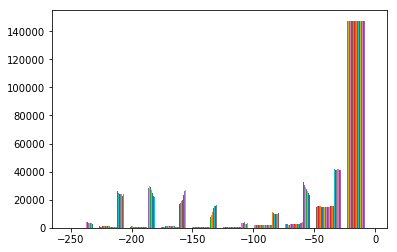

In [11]:
a = c1-c2
plt.hist(a.tolist())